# Drugs Classifier

<hr>

> Using a dataset that has `Age`, `Sex`, `BP`, `Cholesterol`, `Na_to_K` and `Drug`, to build a system that can classify what Drug should be given to a patient giving his/her `Age`, `Sex`, `BP`, `Cholesterol` and `Na_to_K` data as input.

<hr>

#### To ignore sklearn warnings

In [1]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

#### Importing modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score

#### Loading the dataset

In [3]:
df = pd.read_csv('drugs.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64


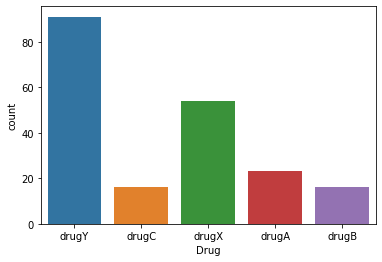

In [4]:
print(df['Drug'].value_counts())
sns.countplot(x='Drug', data=df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


<hr>

## Data Preprocessing

#### Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.113999999999999],
       [28, 'F', 'NORMAL', 'HIGH', 7.797999999999999],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [8]:
le_sex = LabelEncoder()
le_bp = LabelEncoder()
le_cholesterol = LabelEncoder()

X[:, 1] = le_sex.fit_transform(X[:, 1])
X[:, 2] = le_bp.fit_transform(X[:, 2])
X[:, 3] = le_cholesterol.fit_transform(X[:, 3])

X[:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.113999999999999],
       [28, 0, 2, 0, 7.797999999999999],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [9]:
y = df['Drug']
y[:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

#### Splitting the dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

<hr>

## Creating the model

#### Cross Validation

In [11]:
skf = StratifiedKFold(n_splits=10)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [13]:
models = [
    LogisticRegression(), 
    SGDClassifier(), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
]

In [14]:
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=skf)
    print(f'== {model} ==')
    print(f'Cross-Validation mean-score: {scores.mean()}')
    
    print()

== LogisticRegression() ==
Cross-Validation mean-score: 0.8428571428571429

== SGDClassifier() ==
Cross-Validation mean-score: 0.5857142857142856

== KNeighborsClassifier() ==
Cross-Validation mean-score: 0.6500000000000001

== GaussianNB() ==
Cross-Validation mean-score: 0.8642857142857142

== MultinomialNB() ==
Cross-Validation mean-score: 0.7

== DecisionTreeClassifier() ==
Cross-Validation mean-score: 0.9928571428571429

== RandomForestClassifier() ==
Cross-Validation mean-score: 0.9857142857142858

== SVC() ==
Cross-Validation mean-score: 0.6857142857142857



#### Parameter Tuning

In [15]:
def dt_param_selection(X, y, nfolds):
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_depth = [1, 2, 3, 4, 5]

    param_grid = {
        'criterion': criterion, 
        'splitter': splitter, 
        'max_depth': max_depth
    }

    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

best_params_ = dt_param_selection(X_train, y_train, skf)
best_params_

{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}

In [16]:
# Cross Validation

model = DecisionTreeClassifier(criterion='gini', max_depth=4, splitter='best')
scores = cross_val_score(model, X_train, y_train, cv=skf)
print(scores.mean())

0.9928571428571429


#### Fitting the model

In [17]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4, splitter='best')
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

#### Predictions

In [18]:
y_test_pred = model.predict(X_test)
print(f"Prediction: \n{pd.DataFrame(y_test_pred)[0].value_counts()}")

Prediction: 
drugY    23
drugX    20
drugA     7
drugB     5
drugC     5
Name: 0, dtype: int64


In [19]:
print(f"Actual: \n{pd.DataFrame(y_test)['Drug'].value_counts()}")

Actual: 
drugY    22
drugX    21
drugA     7
drugB     5
drugC     5
Name: Drug, dtype: int64


#### Evaluating the model

In [20]:
print(f'Model Score: {model.score(X_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9833333333333333
f1-score: 0.9833152664859981
precision score: 0.9840579710144927
recall score: 0.9833333333333333


In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         5
       drugC       1.00      1.00      1.00         5
       drugX       1.00      0.95      0.98        21
       drugY       0.96      1.00      0.98        22

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60



#### Saving the model

In [23]:
from joblib import dump

dump(model, 'model.joblib')

['model.joblib']

<hr>

## Visualization

In [24]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

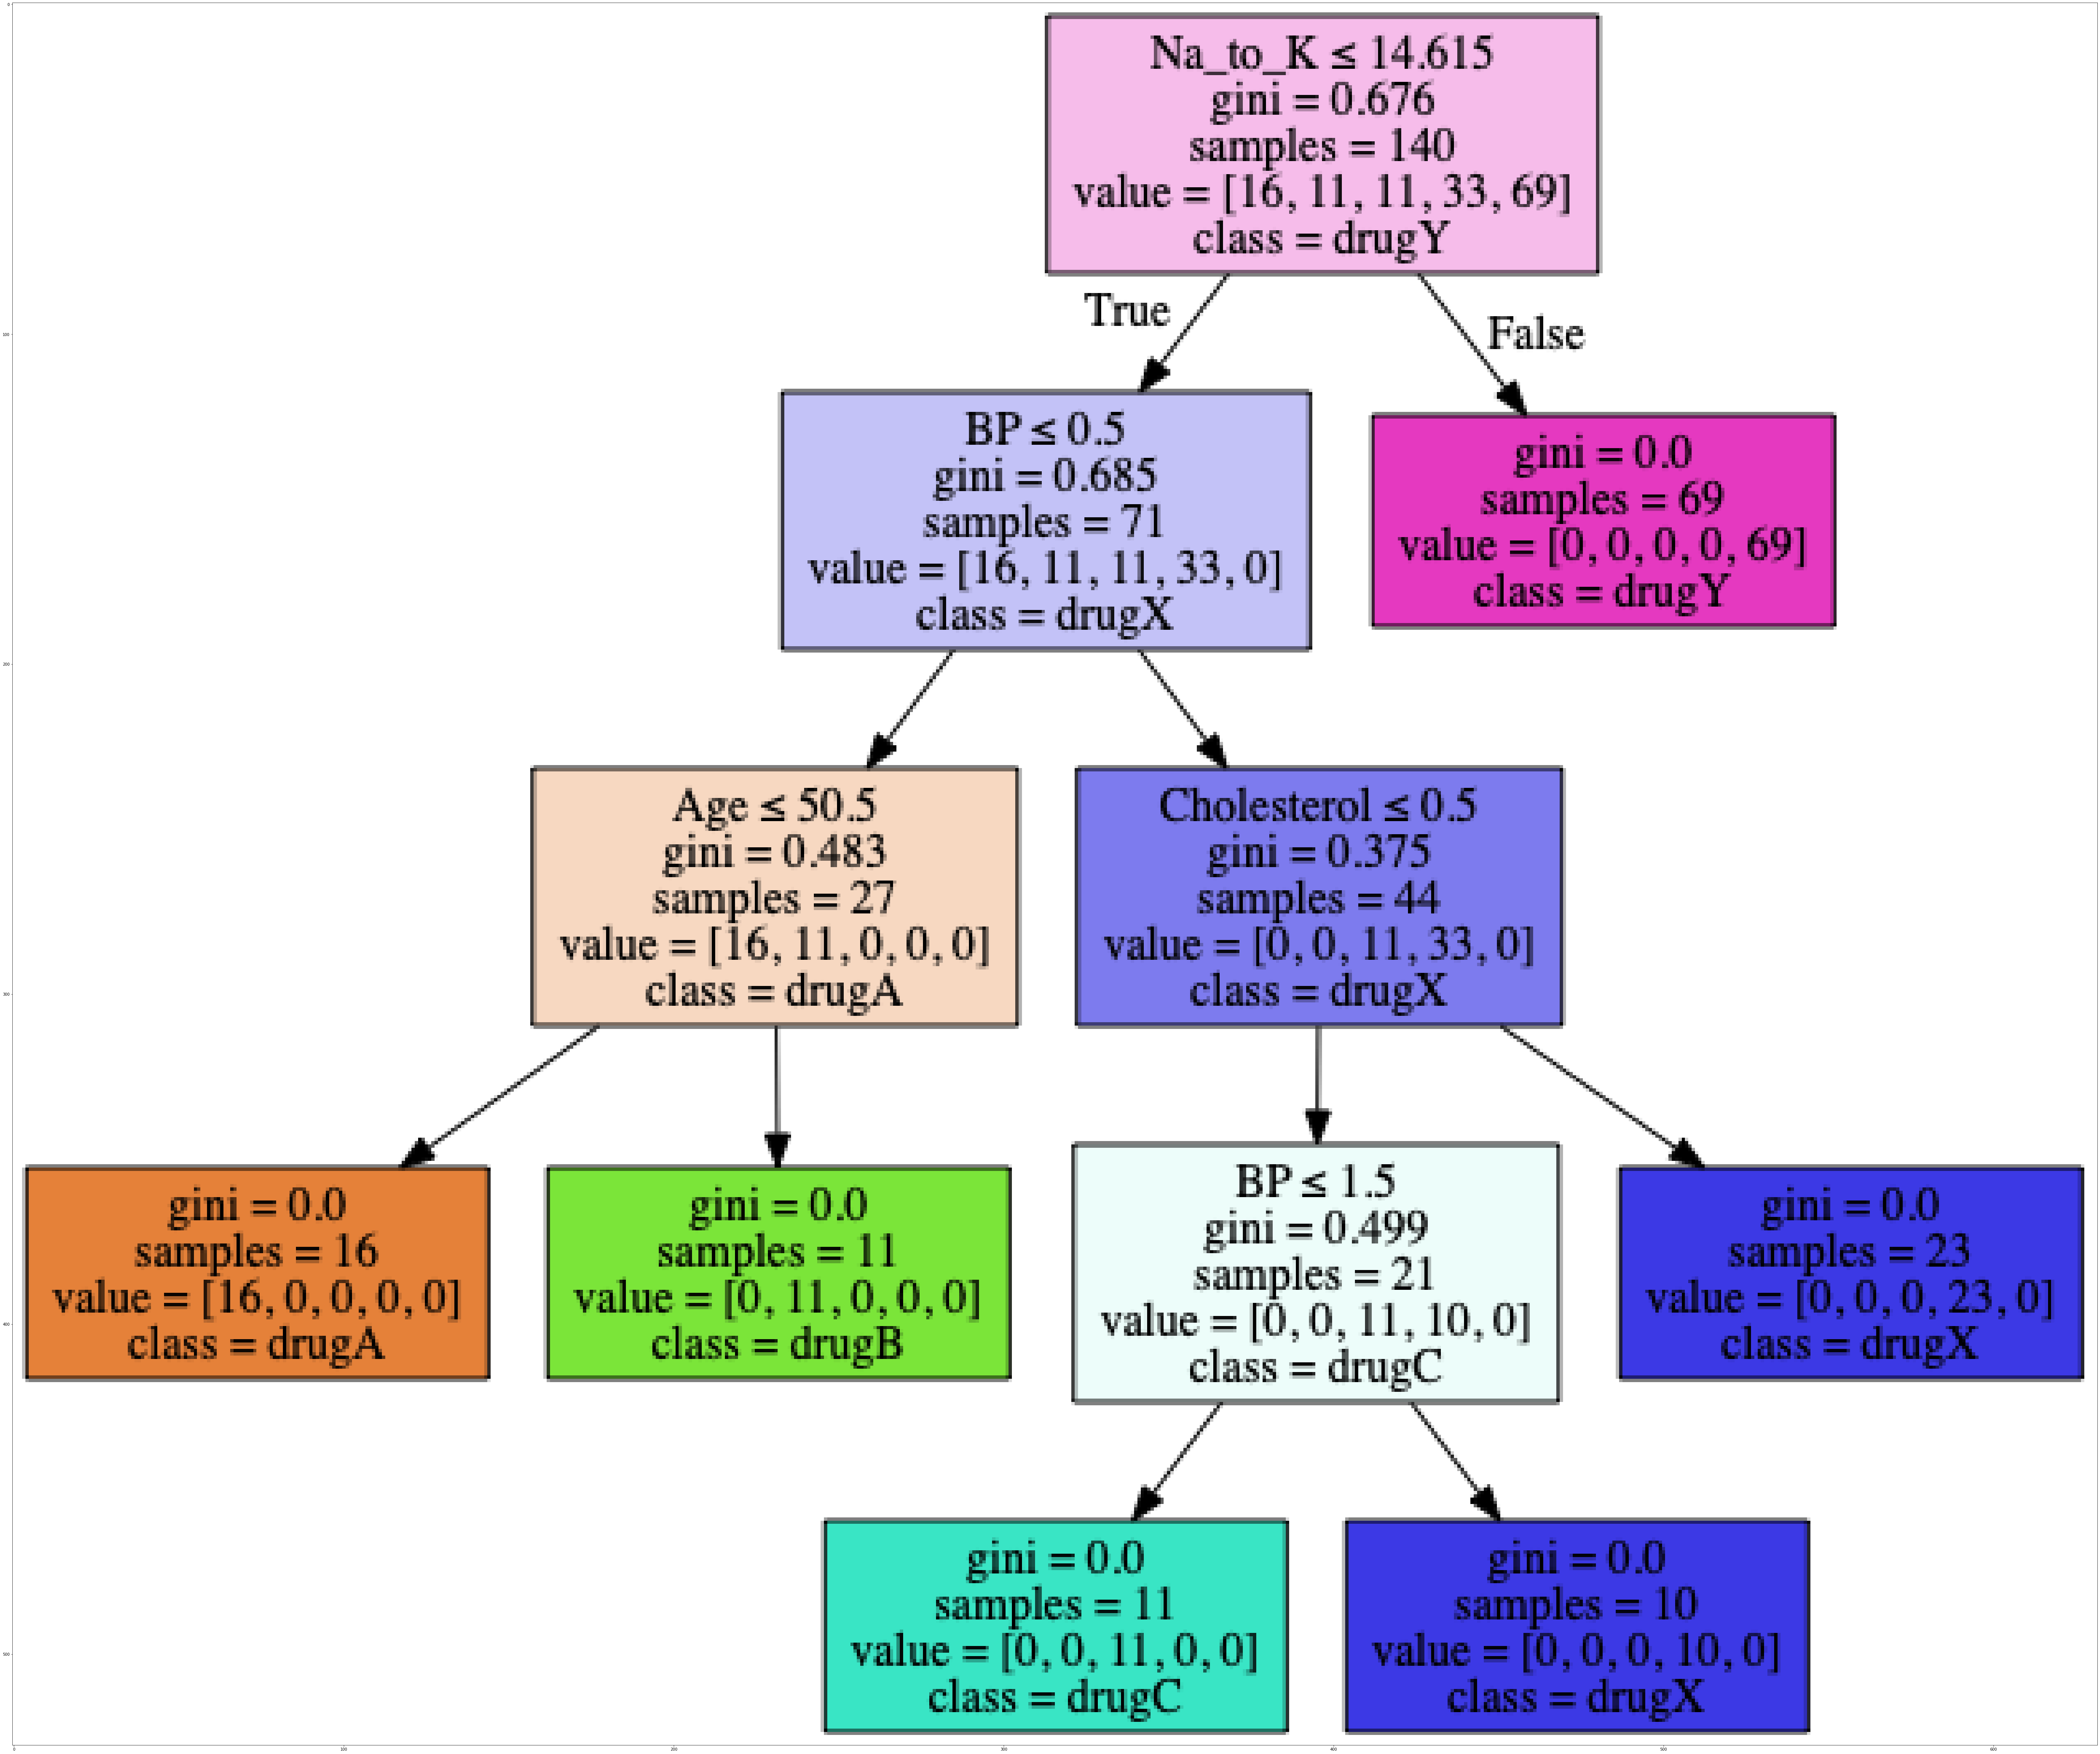

In [25]:
dot_data = StringIO()

filename = "drugtree.png"
featureNames = df.columns[0:5]
targetNames = df["Drug"].unique().tolist()

out=tree.export_graphviz(model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

<hr>